**Locating the Invariant Mass of the Higgs Boson**  
Jeffrey Patrick, Ziyad Zawawi  
Phys 427  
This project is split into two parts, the first comprises of using a neural network to predict the invariant mass of the Higgs Boson. The second involves two neural networks, one to predict a mask which will be used in place of the last cut before filling Lorentz Vectors, and the other to predict the invariant mass of the Higgs Boson. The latter neural network will be trained on the energies, pts, etas, and phis that have been cut by the mask predicted by the neural network.

In [93]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor, MLPClassifier 
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import awkward
import uproot_methods
from scipy.stats import norm

In [2]:
fileA = uproot.open("data_A.GamGam.root")["mini"]
fileB = uproot.open("data_B.GamGam.root")["mini"]
fileC = uproot.open("data_C.GamGam.root")["mini"]
fileD = uproot.open("data_D.GamGam.root")["mini"]

There are four cuts we must apply to the GamGam data in order to select good photons for us to analyze. The first two cuts require the photons the pass the diphoton trigger as well as satisfy the tight identification reconstruction. They are both boolean Jagged Arrays and if any photon is false for either we will cut it out. The next cut requires the transverse momentum of the photon to be greater than 25000 and the absolute value of the psuedo-rapidity to be less than 2.37, as well as less than 1.37 or greater than 1.52. The last cut before we can start creating Lorentz Vectors with the leftover photons has to do with the ratios of the scalar sums of $P_T$ and $E_T$ in cones around the photon over the photon's transverse momemtum. If both ratios are less than 0.065 for both photons in an entry than we create Lorentz Vectors with the values of energy, transverse momemtum, pseudo-rapidity, and the azimuthal angle for that photon pair.

We create Jagged arrays from leaves in the GamGam data and then concatenated them into the single arrays trigger, energies, tightIDS, pt, eta, ptcone30, and etcone20.

In [3]:
PhiA, energiesA, triggerA, isTightIDA, ptA, etaA, ptcone30A, etcone20A = fileA.arrays(["photon_phi", "photon_E", "trigP", "photon_isTightID", "photon_pt", "photon_eta", "photon_ptcone30", "photon_etcone20"], outputtype=tuple)
PhiB, energiesB, triggerB, isTightIDB, ptB, etaB, ptcone30B, etcone20B = fileB.arrays(["photon_phi", "photon_E", "trigP", "photon_isTightID", "photon_pt", "photon_eta", "photon_ptcone30", "photon_etcone20"], outputtype=tuple)
PhiC, energiesC, triggerC, isTightIDC, ptC, etaC, ptcone30C, etcone20C = fileC.arrays(["photon_phi", "photon_E", "trigP", "photon_isTightID", "photon_pt", "photon_eta", "photon_ptcone30", "photon_etcone20"], outputtype=tuple)
PhiD, energiesD, triggerD, isTightIDD, ptD, etaD, ptcone30D, etcone20D = fileD.arrays(["photon_phi", "photon_E", "trigP", "photon_isTightID", "photon_pt", "photon_eta", "photon_ptcone30", "photon_etcone20"], outputtype=tuple)

In [4]:
#arrays of all data concatenated
trigger = awkward.JaggedArray.concatenate([triggerA, triggerB, triggerC, triggerD])
TightIDS = awkward.JaggedArray.concatenate([isTightIDA, isTightIDB, isTightIDC, isTightIDD])
pt = awkward.JaggedArray.concatenate([ptA, ptB, ptC, ptD])
eta = awkward.JaggedArray.concatenate([etaA, etaB, etaC, etaD])
ptcone30 = awkward.JaggedArray.concatenate([ptcone30A, ptcone30B, ptcone30C, ptcone30D])
etcone20 = awkward.JaggedArray.concatenate([etcone20A, etcone20B, etcone20C, etcone20D])
energies = awkward.JaggedArray.concatenate([energiesA, energiesB, energiesC, energiesD])
phi = awkward.JaggedArray.concatenate([PhiA, PhiB, PhiC, PhiD])

The first cut requires the photons to pass the diphoton trigger. Because the trigger array is a boolean Jagged Array, the number of nonzero values in "trigger" would give us the number of Trues. This is due to the fact True=1 and False=0 in integer form. Subtracting the number of trues from the total number of entries in trigger would give us the value of how many photons did not pass the diphoton trigger.

In [5]:
np.size(trigger) - np.count_nonzero(trigger)

0

As we can see from the code, there are no photons that did not pass the diphoton trigger and we can ignore this first cut since it is doing nothing to parse the data.

TightIDS is a boolean Jagged Array with summed values of 0, 1, or 2. If the entry is 2, then both photons satisfy the tight identification reconstruction. We want to create mask1 where values have to be 2, which can then be applied to all of the other arrays in order to filter out the corresponding indices.

In [6]:
#2nd cut, making mask1
ids = TightIDS.sum()
mask1 = ids == 2

Mask2 is made from 3 individual masks. In order to make these masks we needed to apply mask1 to the Jagged Arrays we are using in the cut itself: pt and eta.

In [7]:
#3rd cut, making mask2: pt>25000 & |eta|<2.37 & (|eta|<1.37 or |eta|>1.52)
maskpt = pt[mask1] > 25000

eA = eta[mask1]
masketa = abs(eA) < 2.37
masketa2 = ((abs(eA) < 1.37) | (abs(eA) > 1.52))

mask2 = (maskpt & masketa & masketa2 == True)

In [8]:
#applying mask1 & mask2 to ptcone30, etcone20, and pt
ptcones = ptcone30[mask1]
ptcone = ptcones[mask2]

etcones = etcone20[mask1]
etcone = etcones[mask2]

pts = pt[mask1]
pt1 = pts[mask2]

Creating mask3, where ratios of $ptcone30/pt$ and $etcone20/pt$ have to be less than 0.065. We created 2 masks where each individual ratio has to satisfy this cut, then mask3 required both of these to be true.

In [9]:
#create new cuts with edited arrays
ratio1 = ptcone/pt1
ratio2 = etcone/pt1

maskratio1 = ratio1 < 0.065
maskratio2 = ratio2 < 0.065

mask3 = (maskratio1 & maskratio2 == True)

In [10]:
#applying mask1-3 to energies, pts, phis, and etas
E = energies[mask1]
E1 = E[mask2]
E2 = E1[mask3]

finalpt = pt1[mask3]

phis = phi[mask1]
phi1 = phis[mask2]
phi2 = phi1[mask3]

e = eA[mask2]
e1 = e[mask3]

The final Jagged Arrays: energy, pt_array, eta_array, and phi_array, hold 2 photons per event therefore we split them into left and right arrays which we can use to construct Lorentz Vectors.

In [11]:
energy = E2.choose(2)
leftE = energy.i0.flatten()
rightE = energy.i1.flatten()

pt_array = finalpt.choose(2)
leftpt = pt_array.i0.flatten()
rightpt = pt_array.i1.flatten()

eta_array = e1.choose(2)
lefteta = eta_array.i0.flatten()
righteta = eta_array.i1.flatten()

phi_array = phi2.choose(2)
leftphi = phi_array.i0.flatten()
rightphi = phi_array.i1.flatten()

In [12]:
#constructing the left and right Lorentz Vectors
left = uproot_methods.TLorentzVectorArray.from_ptetaphie(leftpt/1000., lefteta, leftphi, leftE/1000.)
right = uproot_methods.TLorentzVectorArray.from_ptetaphie(rightpt/1000., righteta, rightphi, rightE/1000.)

photon12 = left + right
invmass = np.sqrt(((photon12.t)**2) - ((photon12.x)**2) - ((photon12.y)**2) - ((photon12.z)**2))

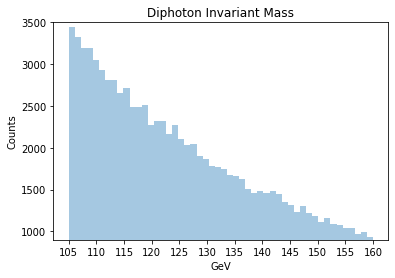

In [13]:
ax = sns.distplot(invmass, kde=False, bins=50, hist_kws={"range":(105,160)})
ax.set(ylim=(900, 3500))
plt.xticks(np.arange(105, 165, step=5))
plt.title('Diphoton Invariant Mass')
plt.xlabel('GeV')
plt.ylabel('Counts')
plt.savefig('Diphoton Invariant Mass.png')
plt.show()

Now that we have a diphoton invariant mass array, we are able to train and test a Neural Network to predict values of the diphoton invariant mass based on the final left and right arrays of energy, pt, eta, and phi.

In [14]:
#contrusting argument to feed Neural Network
lorentzarray = np.column_stack((leftE/1000., rightE/1000., leftpt/1000., rightpt/1000., lefteta, righteta, leftphi, rightphi))

In [15]:
#splitting the argument and invariant mass into odds and evens
odds = lorentzarray[::2]
evens = lorentzarray[1::2]

odds_mass = invmass.flatten()[::2]
evens_mass = invmass.flatten()[1::2]

In [16]:
#creating a Neural Network to predict both the odd and even entries for the diphoton invariant mass
clfe1 = MLPRegressor(hidden_layer_sizes = (6, 3))
clfe1.fit(odds, odds_mass)
masse1_prediction = clfe1.predict(evens)

clfo1 = MLPRegressor(hidden_layer_sizes = (6, 3))
clfo1.fit(evens, evens_mass)
masso1_prediction1 = clfo1.predict(odds)

We create a new diphoton invariant mass array by putting the odd and even neural network predictions back together. We then plotted a histogram of the difference between the invariant mass predicted by the Neural Network and the invariant mass after the cuts.

In [20]:
invmass_new = np.zeros((363877))
invmass_new[::2] = masso1_prediction1
invmass_new[1::2] = masse1_prediction

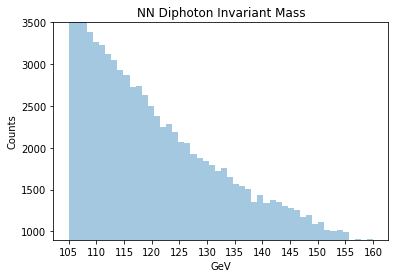

In [44]:
#histogram of NN predicted invariant mass
ax = sns.distplot(invmass_new, kde=False, bins=50, hist_kws={"range":(105,160)})
ax.set(ylim=(900, 3500))
plt.xticks(np.arange(105, 165, step=5))
plt.title('NN Diphoton Invariant Mass')
plt.xlabel('GeV')
plt.ylabel('Counts')
plt.savefig('NN Diphoton Invariant Mass.png')
plt.show()

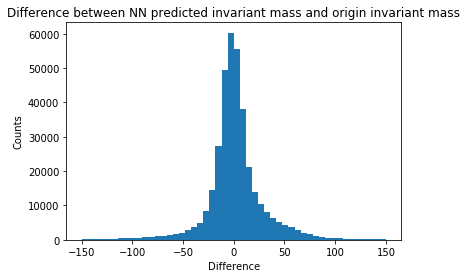

In [90]:
delta_invmass = invmass_new - invmass
plt.hist(delta_invmass, bins=50, range=(-150, 150))
plt.title("Difference between NN predicted invariant mass and origin invariant mass")
plt.savefig('Difference between NN predicted invariant mass and origin invariant mass.png')
plt.xlabel('Difference')
plt.ylabel('Counts')
plt.show()

In [23]:
mean,std=norm.fit(delta_invmass)
print(mean)
print(std)

0.8153778031026089
33.0179413330982


**Capstone PT2, creating mask 3 with neural network instead of explicit cuts**

For the second part of our project we are now training a neural network with the ratios of ptcone30/pt and etcone20/pt to predict a new mask3. The ratios have had mask1 and mask2 already applied. We then used the new mask3 to find an invariant mass which is fed into another neural network to give us a prediction of diphoton invariant mass.

In [24]:
#creating arguments to feed into NN and splitting into odds and evens
x = np.column_stack((ratio1.flatten(), ratio2.flatten()))
y = mask3.flatten()

oddx = x[::2]
evenx = x[1::2]

oddy = y[::2]
eveny = y[1::2]

In [25]:
#2 NN for the odd and even values of a new mask3
evenMask = MLPClassifier(hidden_layer_sizes = (2,1))
evenMask.fit(oddx, oddy)
mask3_evens = evenMask.predict(evenx)

oddMask = MLPClassifier(hidden_layer_sizes = (2,1))
oddMask.fit(evenx, eveny)
mask3_odds = oddMask.predict(oddx)

In order to apply the NN predicted mask3 we must combine the odd and even values and then convert it into a jagged array.

In [27]:
mask3_new = np.zeros((1966618), dtype=bool)
mask3_new[::2] = mask3_odds
mask3_new[1::2] = mask3_evens

mask3_newjag = awkward.JaggedArray.fromoffsets(pt1.offsets, mask3_new.flatten())

Comparison between the neural network mask3 and the original mask3. Deltamask is the integer difference between the two boolean masks. If the difference is 0, the NN mask3 is cutting the same photons as the original mask3. A difference of -1 would mean the NN mask3 isn't passing a photon that original mask3 did. And a difference of 1 would mean it passed a photon that the original didn't. The same logic applies to a difference of 2 or -2.

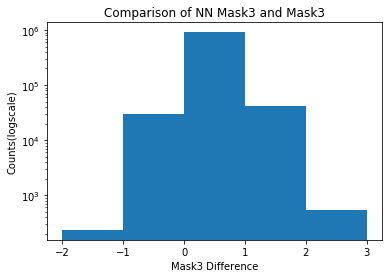

In [91]:
maskinta = mask3_newjag.sum()
maskintb = mask3.sum()

deltamask = (maskinta - maskintb)
plt.hist(deltamask, bins=[-2,-1, 0, 1, 2, 3])
counts, bins = np.histogram(deltamask)
plt.yscale('log')
plt.savefig('Delta Mask.png')
plt.title('Comparison of NN Mask3 and Mask3')
plt.xlabel('Mask3 Difference')
plt.ylabel('Counts(logscale)')
plt.show()

In [92]:
#looking at the number of entries in each bin and dividing by the total number of events in deltamask
print(len(deltamask))
print(counts)

pass1 = (41216/981585)*100
print(pass1)
pass2 = (535/981585)*100
print(pass2)
nopass1 = (29800/981585)*100
print(nopass1)
nopass2 = (235/981585)*100
print(nopass2)
same = (909799/981585)*100
print(same)

981585
[   235      0  29800      0      0 909799      0  41216      0    535]
4.198923170178843
0.05450368536601517
3.0359062129107515
0.02394087114208143
92.68672606040231


In [30]:
#applying new mask3 to the energy, pt, eta, and phi jagged arrays
finalpt1 = pt1[mask3_newjag]
finalE1 = E1[mask3_newjag]
finaleta1 = e[mask3_newjag]
finalphi1 = phi1[mask3_newjag]

In [31]:
energy1 = finalE1.choose(2)
leftE1 = energy1.i0.flatten()
rightE1 = energy1.i1.flatten()

pt_array1 = finalpt1.choose(2)
leftpt1 = pt_array1.i0.flatten()
rightpt1 = pt_array1.i1.flatten()

eta_array1 = finaleta1.choose(2)
lefteta1 = eta_array1.i0.flatten()
righteta1 = eta_array1.i1.flatten()

phi_array1 = finalphi1.choose(2)
leftphi1 = phi_array1.i0.flatten()
rightphi1 = phi_array1.i1.flatten()

In [32]:
left1 = uproot_methods.TLorentzVectorArray.from_ptetaphie(leftpt1/1000., lefteta1, leftphi1, leftE1/1000.)
right1 = uproot_methods.TLorentzVectorArray.from_ptetaphie(rightpt1/1000., righteta1, rightphi1, rightE1/1000.)

photon12_1 = left1 + right1
invmass_NNmask = np.sqrt(((photon12_1.t)**2) - ((photon12_1.x)**2) - ((photon12_1.y)**2) - ((photon12_1.z)**2))

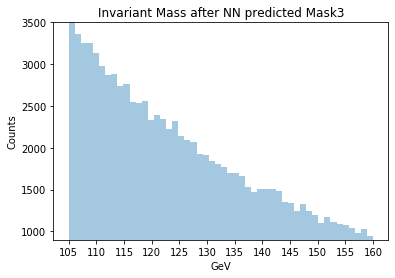

In [57]:
#histogram of invariant mass after applying NN predicted mask3
ax = sns.distplot(invmass_NNmask, kde=False, bins=50, hist_kws={"range":(105,160)})
ax.set(ylim=(900, 3500))
plt.xticks(np.arange(105, 165, step=5))
plt.title('Invariant Mass after NN predicted Mask3')
plt.xlabel('GeV')
plt.ylabel('Counts')
plt.savefig('Invariant Mass after NN predicted Mask3.png')
plt.show()

In [95]:
lorentzarray1 = np.column_stack((leftE1/1000., rightE1/1000., leftpt1/1000., rightpt1/1000., lefteta1, righteta1, leftphi1, rightphi1))
odds1 = lorentzarray1[::2]
evens1 = lorentzarray1[1::2]

odds_mass1 = invmass_NNmask.flatten()[::2]
evens_mass1 = invmass_NNmask.flatten()[1::2]

In [36]:
#2 NN to predict the even and odd values of the diphoton invariant mass
evenMass = MLPRegressor(hidden_layer_sizes = (6, 3))
evenMass.fit(odds1, odds_mass1)
Mass_evens = evenMass.predict(evens1)

oddMass = MLPRegressor(hidden_layer_sizes = (6, 3))
oddMass.fit(evens1, evens_mass1)
Mass_odds = oddMass.predict(odds1)

In [39]:
invmass_new1 = np.zeros((373259))
invmass_new1[::2] = Mass_odds
invmass_new1[1::2] = Mass_evens

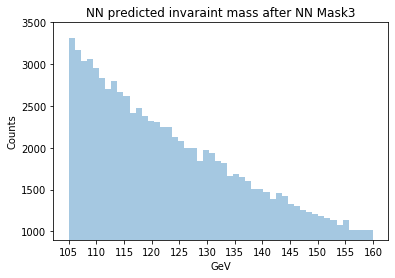

In [58]:
#histogram of NN predicted invariant mass 
ax = sns.distplot(invmass_new1, kde=False, bins=50, hist_kws={"range":(105,160)})
ax.set(ylim=(900, 3500))
plt.xticks(np.arange(105, 165, step=5))
plt.title('NN predicted invaraint mass after NN Mask3')
plt.xlabel('GeV')
plt.ylabel('Counts')
plt.savefig('NN predicted invaraint mass after NN Mask3.png')
plt.show()